In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import rotate

In [2]:
class ImageDataset(Dataset):
    def __init__(self, images):
        self.images = images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        return self.images[index]

In [78]:
def convert_to_tripletBatch_debug(batch):
    """"
    Proccesses a PyTorch-default batch of data sequentially, which (in the form) of a list,
    to return a batch of triplets (one image, its augmentation, and another image)
    or a (one image, its augmentation) pair 
    
    Keyword arguments:
    batch -- a list of images, its length is batch_size
    Return: Tensor with shape (batch_size, 3 or 2, num_channels, height, width)
    """

    print("Here is the batch in `collate_fn`")
    print(batch)
    print("List of Tensor sizes in batch:")
    print([tensor.shape for tensor in batch])

    # get image dimensions, assuming all images are the same size
    # and it is number-of-channels (nc) first
    nc, h, w = batch[0].shape[-3], batch[0].shape[-2], batch[0].shape[-1]

    batch_size = len(batch)


    """to return batches of 3 (original image, augmented original, and another image)
    implies we need at least two separate images to work off of""" 
    if batch_size >= 2:
        print(f"Batch size: {batch_size}")
        # format: (batch_size, 3 for (original, augmented, another), num_channels, height, width)
        images_batch = torch.zeros((batch_size, 3, nc, h, w))
        
        for i in range(batch_size - 1):         
            first_image_index = i
            second_image_index = i + 1 # can be i and i + 1 if we toggle shuffle = True, so that it's random
            first_image = batch[first_image_index]
            second_image = batch[second_image_index]
            first_image_augmented = rotate(first_image, 180)

            images_batch[i, 0, :, :, :] = first_image
            images_batch[i, 1, :, :, :] = first_image_augmented
            images_batch[i, 2, :, :, :] = second_image
        
        images_batch[batch_size-1, 0, :, :, :] = batch[batch_size-1]
        images_batch[batch_size-1, 1, :, :, :] = rotate(batch[batch_size-1], 180)
        images_batch[batch_size-1, 2, :, :, :] = batch[0] 


    # otherwise, just create an (original image, augmented original) pair
    else:
        assert batch_size == 1
        images_batch = torch.zeros((batch_size, 2, nc, h, w))
        images_batch[0, 0, :, :, :] = batch[0]
        images_batch[0, 1, :, :, :] = rotate(batch[0], 180)
        
    return images_batch

In [79]:
(1, *[3, 4])

(1, 3, 4)

# Toy Data Experimentation

In [81]:
images = torch.randn(5, 1, 3, 3)
dataset = ImageDataset(images)
dataloader = DataLoader(dataset, batch_size=2, collate_fn=convert_to_tripletBatch_debug, shuffle=True)

for batch in dataloader:
    batch = batch.view(batch.shape[0]*batch.shape[1], *batch.shape[2:]) 
    print(f"Batch output with shape {batch.shape}")
    print(batch)
    print("\n\n")

Here is the batch in `collate_fn`
[tensor([[[ 1.5769,  1.4792,  0.8732],
         [-0.8146,  0.4392, -3.9703],
         [ 0.4095, -1.4819, -0.1312]]]), tensor([[[ 0.4408, -0.9324, -1.4206],
         [ 0.3458,  0.5147, -1.6704],
         [-0.7350,  0.9249,  0.0024]]])]
List of Tensor sizes in batch:
[torch.Size([1, 3, 3]), torch.Size([1, 3, 3])]
Batch size: 2
Batch output with shape torch.Size([6, 1, 3, 3])
tensor([[[[ 1.5769e+00,  1.4792e+00,  8.7322e-01],
          [-8.1463e-01,  4.3920e-01, -3.9703e+00],
          [ 4.0954e-01, -1.4819e+00, -1.3117e-01]]],


        [[[-1.3117e-01, -1.4819e+00,  4.0954e-01],
          [-3.9703e+00,  4.3920e-01, -8.1463e-01],
          [ 8.7322e-01,  1.4792e+00,  1.5769e+00]]],


        [[[ 4.4078e-01, -9.3241e-01, -1.4206e+00],
          [ 3.4581e-01,  5.1475e-01, -1.6704e+00],
          [-7.3503e-01,  9.2492e-01,  2.4060e-03]]],


        [[[ 4.4078e-01, -9.3241e-01, -1.4206e+00],
          [ 3.4581e-01,  5.1475e-01, -1.6704e+00],
          [-7.350

In [82]:
images.shape

torch.Size([5, 1, 3, 3])

# CelebA

In [83]:
from torchvision.datasets import ImageFolder

class CustomImageFolder(ImageFolder):
    def __init__(self, root, transform=None):
        super(CustomImageFolder, self).__init__(root, transform)

    def __getitem__(self, index):
        path = self.imgs[index][0]
        img = self.loader(path)

        if self.transform is not None:
            img = self.transform(img)

        return img


In [84]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(), ])

train_kwargs = {'root': "./data/CelebA", 'transform': transform}
celeba_data = CustomImageFolder(**train_kwargs)

In [85]:
len(celeba_data)

202599

In [52]:
BATCH_SIZE = 5

In [86]:
celeba_dataloader = DataLoader(celeba_data, batch_size=BATCH_SIZE, 
                               collate_fn=convert_to_tripletBatch_debug, shuffle=True)

In [87]:
def show_triplets_in_batch(dataloader: DataLoader):
    import matplotlib.pyplot as plt

    fig, axs = plt.subplots(BATCH_SIZE, 3, figsize=(15, 15))

    batch = next(iter(dataloader))
    titles = ['Image 1', 'Augmented 1', 'Image 2']

    for batch_idx, triplet in enumerate(batch):
        for triplet_idx, image in enumerate(triplet):
            axs[batch_idx, triplet_idx].imshow(torch.permute(image, (1, 2, 0)))
            axs[batch_idx, triplet_idx].set_title(titles[triplet_idx])

    fig.suptitle(f'Batch of {BATCH_SIZE} Triplets')

    plt.show()


Here is the batch in `collate_fn`
[tensor([[[0.9333, 0.9686, 0.8000,  ..., 0.0471, 0.0510, 0.0471],
         [0.9333, 0.9686, 0.8000,  ..., 0.0471, 0.0510, 0.0471],
         [0.9373, 0.9686, 0.7961,  ..., 0.0471, 0.0510, 0.0471],
         ...,
         [0.1804, 0.1569, 0.1451,  ..., 0.1529, 0.1569, 0.1529],
         [0.1490, 0.1412, 0.1373,  ..., 0.1569, 0.1608, 0.1529],
         [0.1412, 0.1333, 0.1333,  ..., 0.1608, 0.1608, 0.1608]],

        [[0.6745, 0.6627, 0.5490,  ..., 0.0510, 0.0549, 0.0510],
         [0.6745, 0.6627, 0.5490,  ..., 0.0510, 0.0549, 0.0510],
         [0.6745, 0.6627, 0.5451,  ..., 0.0510, 0.0549, 0.0510],
         ...,
         [0.1843, 0.1647, 0.1451,  ..., 0.1569, 0.1608, 0.1569],
         [0.1529, 0.1412, 0.1373,  ..., 0.1608, 0.1647, 0.1569],
         [0.1412, 0.1333, 0.1294,  ..., 0.1647, 0.1647, 0.1647]],

        [[0.3098, 0.2824, 0.2549,  ..., 0.0196, 0.0235, 0.0196],
         [0.3098, 0.2824, 0.2549,  ..., 0.0196, 0.0235, 0.0196],
         [0.3137, 0.282

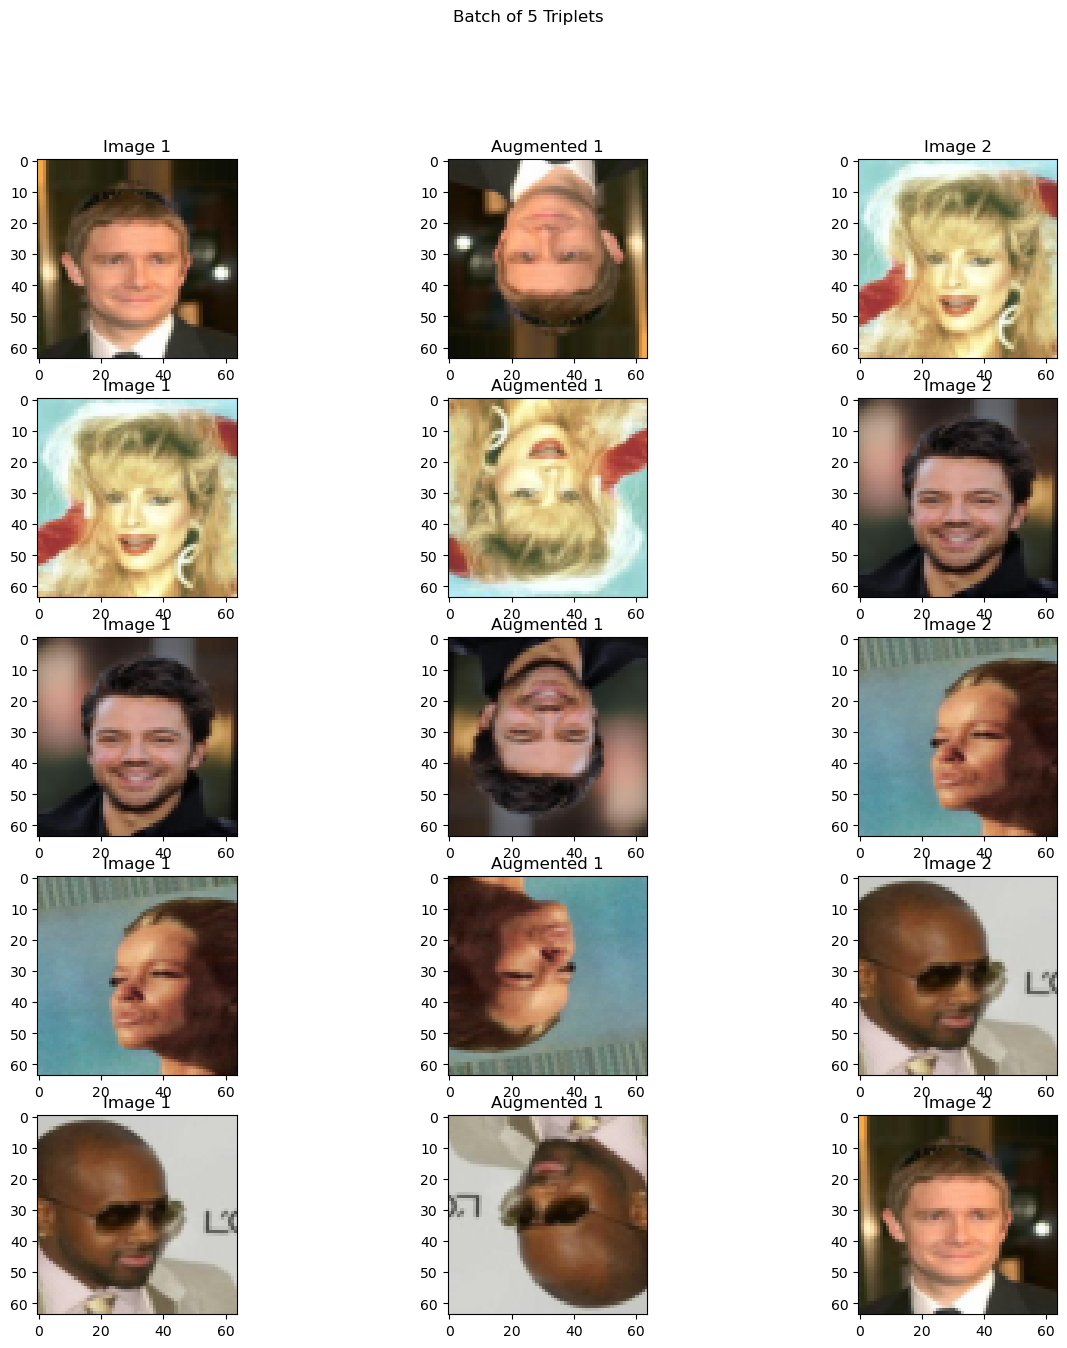

In [88]:
show_triplets_in_batch(celeba_dataloader)

# 3DChairs

In [89]:
def convert_to_tripletBatch(batch):
    """"
    Proccesses a batch of data sequentially (in the form) of a list
    to return a batch of triplets (one image, its augmentation, and another image)
    or a (one image, its augmentation) pair 
    
    Keyword arguments:
    batch -- a list of images, its length is batch_size
    Return: Tensor with shape (batch_size, 3 or 2, num_channels, height, width)
    """

    # get image dimensions, assuming all images are the same size
    # and it is number-of-channels (nc) first
    nc, h, w = batch[0].shape[-3], batch[0].shape[-2], batch[0].shape[-1]
    batch_size = len(batch)

    """to return batches of 3 (original image, augmented original, and another image)
    implies we need at least two separate images to work off of""" 
    if batch_size >= 2:
        print(f"Batch size: {batch_size}")
        # format: (batch_size, 3 for (original, augmented, another), num_channels, height, width)
        images_batch = torch.zeros((batch_size, 3, nc, h, w))
        
        for i in range(batch_size - 1):         
            first_image_index = i
            second_image_index = i + 1 # can be i and i + 1 if we toggle shuffle = True, so that it's random
            first_image = batch[first_image_index]
            second_image = batch[second_image_index]
            first_image_augmented = rotate(first_image, 180)

            images_batch[i, 0, :, :, :] = first_image
            images_batch[i, 1, :, :, :] = first_image_augmented
            images_batch[i, 2, :, :, :] = second_image
        
        images_batch[batch_size-1, 0, :, :, :] = batch[batch_size-1]
        images_batch[batch_size-1, 1, :, :, :] = rotate(batch[batch_size-1], 180)
        images_batch[batch_size-1, 2, :, :, :] = batch[0] 


    # otherwise, just create an (original image, augmented original) pair
    else:
        assert batch_size == 1
        images_batch = torch.zeros((batch_size, 2, nc, h, w))
        images_batch[0, 0, :, :, :] = batch[0]
        images_batch[0, 1, :, :, :] = rotate(batch[0], 180)
        
    return images_batch

In [90]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(), ])

train_kwargs = {'root': "./data/3DChairs", 'transform': transform}
chairs3D_data = CustomImageFolder(**train_kwargs)

In [91]:
chairs3D_dataloader = DataLoader(chairs3D_data, batch_size=BATCH_SIZE, 
                                 collate_fn=convert_to_tripletBatch, shuffle=True)

Batch size: 5


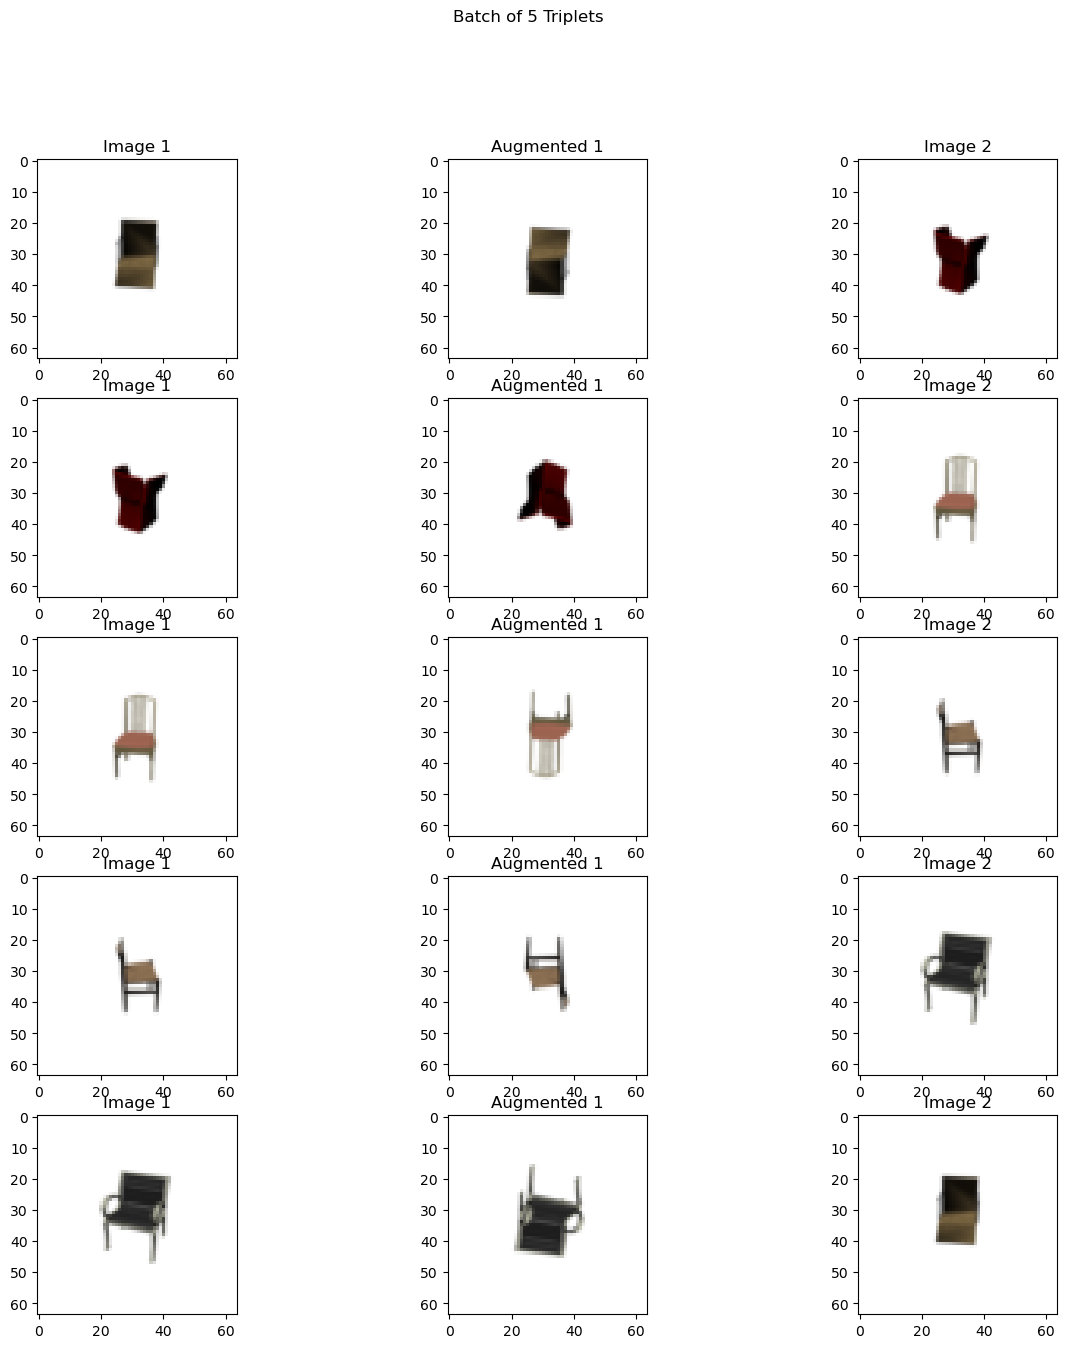

In [92]:
show_triplets_in_batch(chairs3D_dataloader)